In [29]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
from torch.utils import data
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch.utils.data import random_split
from timeit import default_timer as timer 


import yaml
from datafactory import EuroSAT, train_transform, test_transform, imagenet_mean, imagenet_std 
from engine import train
from utils import *

In [30]:
# read  config
cfg_path = "config.yaml"
with open(cfg_path) as f:
    config = yaml.safe_load(f)

config

{'dataset_name': 'EuroSAT',
 'data_dir': './data/EuroSAT/2750/',
 'save_path': './outputs/',
 'seed': 42,
 'num_classes': 10,
 'train_ratio': 0.8,
 'val_ratio': 0.2,
 'percentage_per_class': 0.3,
 'batch_size': 32,
 'num_epochs': 10,
 'lr': 0.001,
 'weight_decay': 0.05,
 'use_scheduler': False,
 'scheduler_type': 'lambdalr',
 'warmup_epochs': 3}

In [31]:
SAVE_PATH  = config['save_path']

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [4]:
# Set seed for reproducibility
set_seeds(seed=config['seed'])

# Get number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Print the 3 values
print(f"Seed: {config['seed']}")
print(f"Number of workers: {NUM_WORKERS}")
print(f"Device: {device}")

# Get specific GPU model
if str(device) == "cuda":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))


Seed: 42
Number of workers: 16
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [5]:
# Load the dataset
data_dir = config['data_dir']

dataset = datasets.ImageFolder(data_dir)

# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


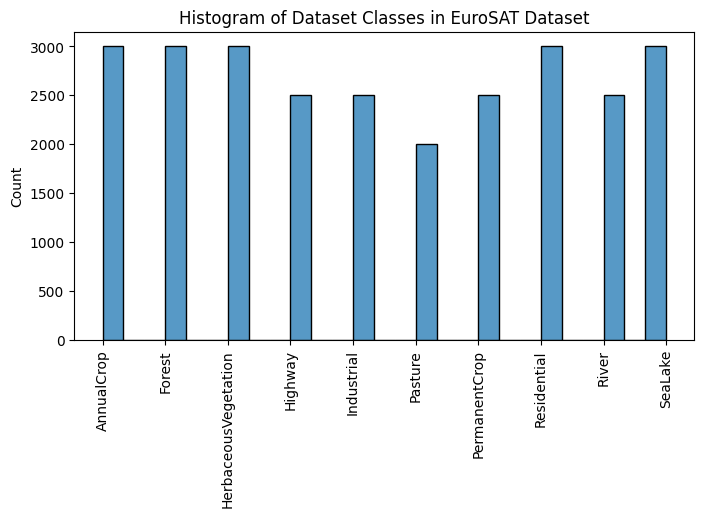

In [6]:
plt.figure(figsize=(8, 4))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()

In [7]:
# Apply different transformations to the training and test sets
train_data = EuroSAT(dataset, train_transform)
test_data = EuroSAT(dataset, test_transform)

# Randomly split the dataset into 80% train / 20% test
# by subsetting the transformed train and test datasets
train_size = config['train_ratio']
indices = list(range(int(len(dataset))))
split = int(train_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:split])
test_data = data.Subset(test_data, indices=indices[split:])
print("Train/test sizes: {}/{}".format(len(train_data), len(test_data)))

Train/test sizes: 21600/5400


In [8]:
# Sample 30% of each class from the original train_data
filtered_train_data = sample_subset_per_class(train_data, percentage=config['percentage_per_class'])


Sampling per class:


100%|██████████| 10/10 [00:00<00:00, 651.06it/s]

✅ Sampling completed in 223.81 seconds.


In [9]:
# Then split into train and val
val_split = config['val_ratio']
val_len = int(len(filtered_train_data) * val_split)
train_len = len(filtered_train_data) - val_len
train_small, val_small = random_split(filtered_train_data, [train_len, val_len])

print("Train/val sizes: {}/{}".format(len(train_small), len(val_small)))

Train/val sizes: 5180/1294


In [10]:
# Create DataLoaders
train_loader = DataLoader(train_small, batch_size=config['batch_size'], shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_small, batch_size=config['batch_size'], shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=False, num_workers=NUM_WORKERS)

In [11]:
batchX0, batchy0 = next(iter(train_loader))
batchX0.shape, batchy0.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

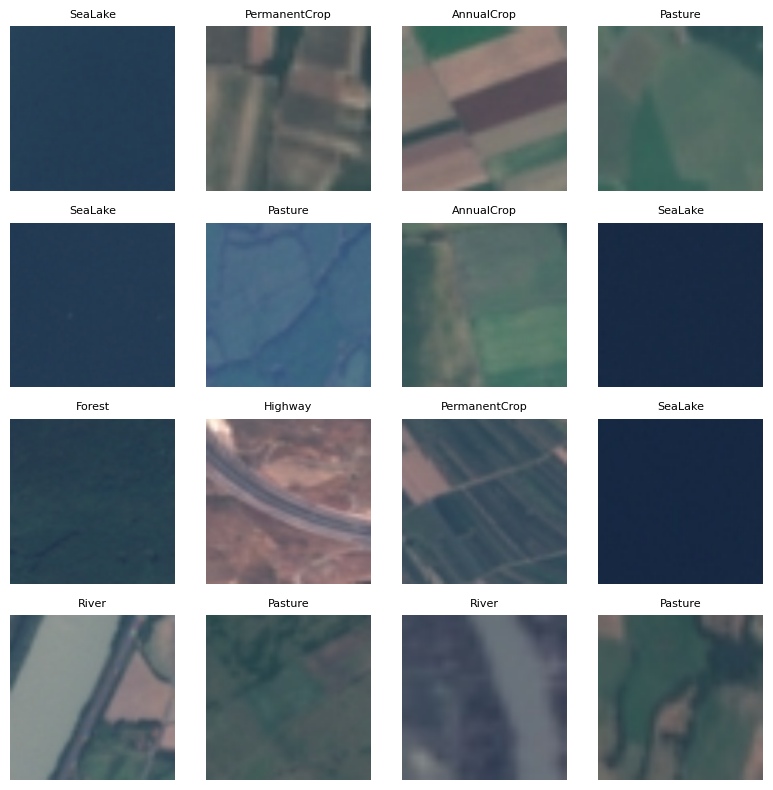

In [12]:
visualize_batch(train_loader, class_names, mean=imagenet_mean, std=imagenet_std, n=4)

In [13]:
import torch
from torchvision import models
from torchvision.models import ViT_B_16_Weights

# Load pretrained ViT base model (vit_b_16)
weights = ViT_B_16_Weights.DEFAULT
model = models.vit_b_16(weights=weights)

# Replace the classification head
model.heads.head = torch.nn.Linear(model.heads.head.in_features, len(dataset.classes))
model = model.to(device)

# Print model summary (ViT expects 224x224 RGB images)
from torchinfo import summary
summary(model, input_size= batchX0.shape)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [32, 10]                  768
├─Conv2d: 1-1                                 [32, 768, 14, 14]         590,592
├─Encoder: 1-2                                [32, 197, 768]            151,296
│    └─Dropout: 2-1                           [32, 197, 768]            --
│    └─Sequential: 2-2                        [32, 197, 768]            --
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-3                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-4                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-5                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-6                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-7             

In [14]:
# Specify criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'])

# optimizer = torch.optim.AdamW(model.parameters(),
#                                 lr=config['lr'],
#                                 weight_decay=config['weight_decay'])

In [ ]:
best_name = SAVE_PATH  + "best_model.pth"
    
start_time = timer()
results, best_model = train(model=model,
                            train_dataloader=train_loader,
                            val_dataloader= val_loader,
                            optimizer=optimizer,
                            loss_fn=criterion,
                            device= device,
                            epochs=config['num_epochs'],
                            model_save_path=best_name,
                            use_scheduler=config['use_scheduler'],
                        )

# Synchronize to ensure timing is accurate
torch.cuda.synchronize()
end_time = timer()



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6412 | train_acc: 0.5459 | val_loss: 1.1480 | val_acc: 0.7446 | 


 10%|█         | 1/10 [03:25<30:50, 205.63s/it]

✅ Best model saved with accuracy: 0.7446
Epoch: 2 | train_loss: 0.9164 | train_acc: 0.7973 | val_loss: 0.7575 | val_acc: 0.8399 | 


 20%|██        | 2/10 [06:57<27:55, 209.48s/it]

✅ Best model saved with accuracy: 0.8399
Epoch: 3 | train_loss: 0.6448 | train_acc: 0.8506 | val_loss: 0.5725 | val_acc: 0.8626 | 


 30%|███       | 3/10 [10:17<23:54, 204.89s/it]

✅ Best model saved with accuracy: 0.8626
Epoch: 4 | train_loss: 0.5011 | train_acc: 0.8776 | val_loss: 0.4461 | val_acc: 0.8875 | 


 40%|████      | 4/10 [12:29<17:37, 176.19s/it]

✅ Best model saved with accuracy: 0.8875
Epoch: 5 | train_loss: 0.4120 | train_acc: 0.8970 | val_loss: 0.4043 | val_acc: 0.8933 | 


 50%|█████     | 5/10 [14:41<13:21, 160.39s/it]

✅ Best model saved with accuracy: 0.8933
Epoch: 6 | train_loss: 0.3582 | train_acc: 0.9021 | val_loss: 0.3501 | val_acc: 0.9002 | 


 60%|██████    | 6/10 [16:53<10:03, 150.79s/it]

✅ Best model saved with accuracy: 0.9002
Epoch: 7 | train_loss: 0.3138 | train_acc: 0.9156 | val_loss: 0.3026 | val_acc: 0.9116 | 


 70%|███████   | 7/10 [19:05<07:13, 144.61s/it]

✅ Best model saved with accuracy: 0.9116
Epoch: 8 | train_loss: 0.2807 | train_acc: 0.9218 | val_loss: 0.2819 | val_acc: 0.9238 | 


 80%|████████  | 8/10 [21:17<04:41, 140.56s/it]

✅ Best model saved with accuracy: 0.9238


 90%|█████████ | 9/10 [23:29<02:17, 137.67s/it]

Epoch: 9 | train_loss: 0.2748 | train_acc: 0.9229 | val_loss: 0.2712 | val_acc: 0.9192 | 


100%|██████████| 10/10 [25:40<00:00, 154.08s/it]

Epoch: 10 | train_loss: 0.2443 | train_acc: 0.9315 | val_loss: 0.2638 | val_acc: 0.9159 | 
Loading the best model for further tasks...


NameError: name 'print_train_time' is not defined

In [32]:
train_time = print_train_time(start=start_time, end=end_time, device=device)

print(max(results['val_acc']))


NameError: name 'print_train_time' is not defined

Training results saved to ./outputs/train_report.txt


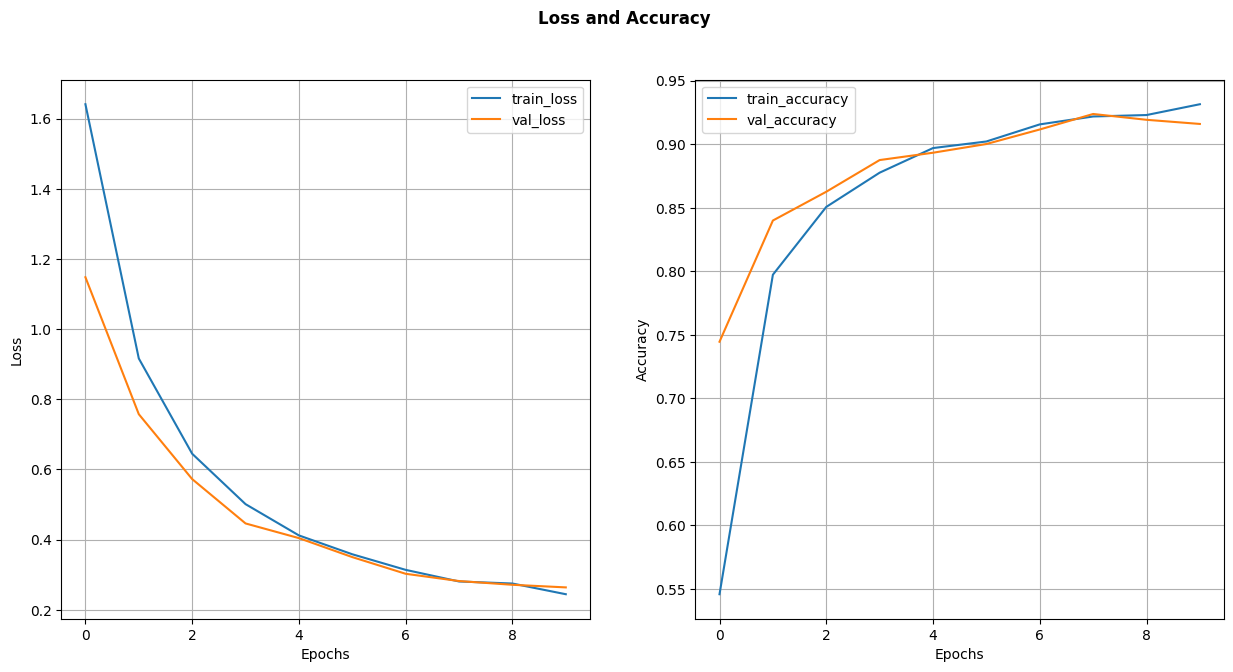

In [17]:
# Save the training results
save_training_results(results, SAVE_PATH + 'train_report.txt')

plot_loss_acc_curves(results, 
                    save_path= SAVE_PATH  +'loss_acc_curves.png',
                    title= "Loss and Accuracy")

In [18]:
model_file = SAVE_PATH  + "best_model.pth"
torch.save(best_model, best_name)
print('Model successfully saved to {}'.format(model_file))

Model successfully saved to ./outputs/best_model.pth


In [25]:
model = torch.load(model_file, weights_only = False)
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Model file ./outputs/best_model.pth successfully loaded.


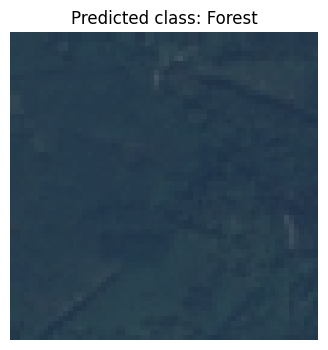

In [27]:
img_path = './data/EuroSAT/2750/Forest/Forest_1.jpg'
predicted_class = predict_and_visualize(
    image_path=img_path,
    model=model,
    transform=test_transform,
    class_names=class_names,
    device=device
)